In [ ]:
# installing and importing protparam library
!pip install biopython
from Bio.SeqUtils import ProtParam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.3 MB/s eta 0:00:00


In [ ]:
# importing necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import copy
import numpy as np
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
df = pd.read_csv('/content/phospho_dataset.csv') # loading the dataset

In [ ]:
# function to split amino_acid_composition feature to multiple features
def expand_amino_acid_composition(data):
    return pd.Series(data['amino_acid_composition'])
# function to split secondary_structure_fraction feature to multiple features
def expand_secondary_structure_fraction(data):
    return pd.Series(data['secondary_structure_fraction'])

In [ ]:
# function to extract features using protparam (approach2)
def get_features(data):
  features = []
  for seq in data['Extracted_Sequence']:
    try:

      aa_comp = ProtParam.ProteinAnalysis(str(seq)).get_amino_acids_percent()
      mol_wt = ProtParam.ProteinAnalysis(str(seq)).molecular_weight()
      aroma = ProtParam.ProteinAnalysis(str(seq)).aromaticity()
      insta_ind = ProtParam.ProteinAnalysis(str(seq)).instability_index()
      isoelec_pnt = ProtParam.ProteinAnalysis(str(seq)).isoelectric_point()
      sec_struc_frac = ProtParam.ProteinAnalysis(str(seq)).secondary_structure_fraction()
      feature = {
          "amino_acid_composition": aa_comp,
          "molecular_weight": mol_wt,
          "aromaticity": aroma,
          "instability_index": insta_ind,
          "isoelectric_point": isoelec_pnt,
          "secondary_structure_fraction": sec_struc_frac
      }
    except:
      pass
    features.append(feature)
  features = pd.DataFrame(features)
  amino_comp_df = features.apply(expand_amino_acid_composition, axis=1)
  secondary_structure_fraction_df = features.apply(expand_secondary_structure_fraction, axis=1)
  secondary_structure_fraction_df.columns = ['secondary_structure_fraction_x','secondary_structure_fraction_y','secondary_structure_fraction_z']
  features = pd.concat([features, amino_comp_df, secondary_structure_fraction_df], axis=1)
  features.drop(['amino_acid_composition', 'secondary_structure_fraction'], axis=1, inplace=True)
  return features, data['Target']

In [ ]:
# function to compute amiono acid composition
def compute_aa_composition_features(data):
    features = []
    for seq in data['Extracted_Sequence']:

        aa_comp = ProtParam.ProteinAnalysis(str(seq)).get_amino_acids_percent()

        features.append(list(aa_comp.values()))

    return np.array(features)



In [ ]:
# function to extract features using protparam (approach1)
def extract_feature(df):
  df['length'] = df['Extracted_Sequence'].apply(len)
  df_aa = compute_aa_composition_features(df)
  vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2,2))
  df_vectorized = vectorizer.fit_transform(df['Extracted_Sequence'])
  df_vectorized = np.hstack([df_vectorized.toarray(), df['length'].values.reshape(-1,1), df_aa])
  df_target = df['Target']
  return df_vectorized, df_target

# **Protparam dataset**

In [ ]:
# extracting features and target using protparam approach2
data, target  = get_features(df)
data

,molecular_weight,aromaticity,instability_index,isoelectric_point,A,C,D,E,F,G,...,Q,R,S,T,V,W,Y,secondary_structure_fraction_x,secondary_structure_fraction_y,secondary_structure_fraction_z
0,1776.0817,0.133333,43.886667,6.061162,0.066667,0.066667,0.066667,0.066667,0.066667,0.000000,...,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.066667,0.533333,0.200000,0.400000
1,1738.8498,0.066667,9.213333,6.005972,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,...,0.066667,0.066667,0.200000,0.133333,0.066667,0.000000,0.066667,0.266667,0.333333,0.333333
2,1677.8972,0.133333,11.880000,8.902649,0.000000,0.000000,0.066667,0.000000,0.000000,0.133333,...,0.066667,0.066667,0.066667,0.000000,0.200000,0.000000,0.133333,0.133333,0.400000,0.400000
3,1710.1163,0.000000,6.240000,8.231146,0.066667,0.066667,0.000000,0.066667,0.000000,0.066667,...,0.000000,0.066667,0.000000,0.000000,0.066667,0.000000,0.000000,0.466667,0.133333,0.400000
4,1858.0646,0.200000,76.100000,8.042447,0.000000,0.133333,0.066667,0.000000,0.000000,0.066667,...,0.066667,0.133333,0.066667,0.000000,0.000000,0.000000,0.200000,0.000000,0.333333,0.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57230,1640.8289,0.266667,24.740000,5.184876,0.066667,0.000000,0.000000,0.000000,0.200000,0.066667,...,0.000000,0.000000,0.200000,0.200000,0.066667,0.000000,0.066667,0.200000,0.266667,0.666667
57231,1875.2688,0.200000,88.020000,10.352349,0.066667,0.066667,0.000000,0.000000,0.200000,0.000000,...,0.000000,0.133333,0.066667,0.000000,0.000000,0.000000,0.000000,0.200000,0.133333,0.400000
57232,1782.0995,0.000000,24.740000,11.999968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.200000,0.133333,0.000000,0.133333,0.000000,0.000000,0.133333,0.333333,0.400000
57233,1794.9280,0.066667,189.500000,11.523289,0.133333,0.000000,0.133333,0.000000,0.000000,0.000000,...,0.066667,0.266667,0.133333,0.000000,0.000000,0.066667,0.000000,0.133333,0.466667,0.066667


In [ ]:
# function to split data and pre-process its shape
def split_data(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
  x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
  x_val = x_val.reshape(x_val.shape[0], 1, x_val.shape[1])
  x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
  return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
# function to create Bidirectional model
def create_model(data):
  model = tf.keras.Sequential([
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), input_shape=(1, data.shape[2]), return_sequences=True),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), return_sequences=True),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid'),
  ])
  return model

In [ ]:
# function to compile model and fit model
def train(model, opt, epoch, batch, x_train, y_train, x_val, y_val):
  model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  hist = model.fit(x_train, y_train, epochs=epoch, batch_size=batch, validation_data=(x_val, y_val), callbacks=[early_stopping])
  return  model, hist

In [ ]:
# function to evaluate score
def evaluate_score(model, x_test, y_test):
  _, acc, prec, rec = model.evaluate(x_test, y_test)
  try:
    f1_score = (2*prec*rec)/(prec+rec)
  except:
    f1_score = 0
  print("Accuracy  :", acc)
  print("Precision :", prec)
  print("Recall    :", rec)
  print("F1-Score  :", f1_score)

In [ ]:
# function to create plot
def plot(hist):
  plt.plot(hist[1].history['accuracy'])
  plt.plot(hist[1].history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend([' Train', 'Test'], loc='upper left')
  plt.show()

In [ ]:
# preprocessing the data and create model
x = data.values
sc = StandardScaler()
x = sc.fit_transform(x)
y = target.values
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y)
model = create_model(x_train)

In [ ]:
# training model and evaluating scores with different batch size and optimizers and iterations

Epoch 1/100
501/501 [==============================] - 14s 14ms/step - loss: 0.6660 - accuracy: 0.6366 - precision: 0.6153 - recall: 0.6293 - val_loss: 0.6300 - val_accuracy: 0.6543 - val_precision: 0.6200 - val_recall: 0.6842
Epoch 2/100
501/501 [==============================] - 5s 10ms/step - loss: 0.6335 - accuracy: 0.6601 - precision: 0.6417 - recall: 0.6460 - val_loss: 0.6194 - val_accuracy: 0.6614 - val_precision: 0.6262 - val_recall: 0.6945
Epoch 3/100
501/501 [==============================] - 5s 9ms/step - loss: 0.6268 - accuracy: 0.6630 - precision: 0.6440 - recall: 0.6513 - val_loss: 0.6123 - val_accuracy: 0.6652 - val_precision: 0.6313 - val_recall: 0.6924
Epoch 4/100
501/501 [==============================] - 6s 12ms/step - loss: 0.6218 - accuracy: 0.6688 - precision: 0.6515 - recall: 0.6526 - val_loss: 0.6100 - val_accuracy: 0.6642 - val_precision: 0.6282 - val_recall: 0.7001
Epoch 5/100
501/501 [==============================] - 5s 9ms/step - loss: 0.6187 - accuracy: 0.

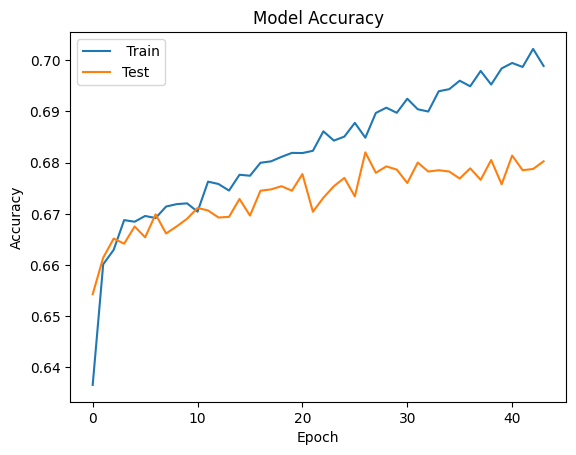

Epoch 1/100
251/251 [==============================] - 12s 17ms/step - loss: 0.5786 - accuracy: 0.6965 - precision_1: 0.6926 - recall_1: 0.6507 - val_loss: 0.5960 - val_accuracy: 0.6801 - val_precision_1: 0.6601 - val_recall_1: 0.6592
Epoch 2/100
251/251 [==============================] - 4s 16ms/step - loss: 0.5769 - accuracy: 0.6950 - precision_1: 0.6937 - recall_1: 0.6424 - val_loss: 0.5958 - val_accuracy: 0.6800 - val_precision_1: 0.6592 - val_recall_1: 0.6616
Epoch 3/100
251/251 [==============================] - 4s 15ms/step - loss: 0.5770 - accuracy: 0.6954 - precision_1: 0.6933 - recall_1: 0.6448 - val_loss: 0.5953 - val_accuracy: 0.6784 - val_precision_1: 0.6556 - val_recall_1: 0.6659
Epoch 4/100
251/251 [==============================] - 3s 12ms/step - loss: 0.5746 - accuracy: 0.6995 - precision_1: 0.7001 - recall_1: 0.6442 - val_loss: 0.5946 - val_accuracy: 0.6801 - val_precision_1: 0.6649 - val_recall_1: 0.6446
Epoch 5/100
251/251 [==============================] - 3s 12ms/

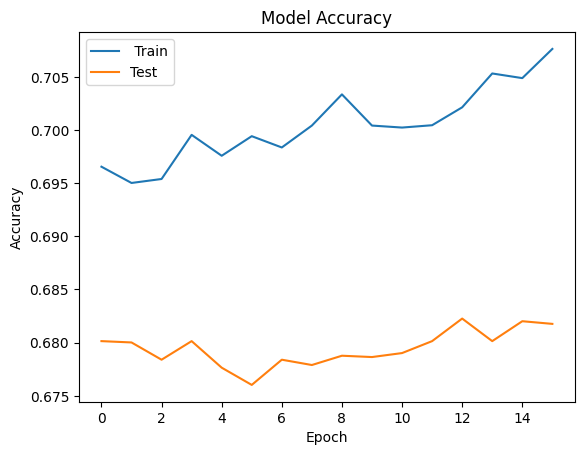

Epoch 1/100
126/126 [==============================] - 11s 27ms/step - loss: 0.5741 - accuracy: 0.6977 - precision_2: 0.6959 - recall_2: 0.6471 - val_loss: 0.5947 - val_accuracy: 0.6803 - val_precision_2: 0.6731 - val_recall_2: 0.6223
Epoch 2/100
126/126 [==============================] - 2s 16ms/step - loss: 0.5712 - accuracy: 0.7019 - precision_2: 0.7046 - recall_2: 0.6424 - val_loss: 0.5941 - val_accuracy: 0.6779 - val_precision_2: 0.6576 - val_recall_2: 0.6574
Epoch 3/100
126/126 [==============================] - 2s 16ms/step - loss: 0.5700 - accuracy: 0.7032 - precision_2: 0.7023 - recall_2: 0.6526 - val_loss: 0.5960 - val_accuracy: 0.6768 - val_precision_2: 0.6654 - val_recall_2: 0.6287
Epoch 4/100
126/126 [==============================] - 2s 15ms/step - loss: 0.5698 - accuracy: 0.7018 - precision_2: 0.7032 - recall_2: 0.6455 - val_loss: 0.5964 - val_accuracy: 0.6796 - val_precision_2: 0.6609 - val_recall_2: 0.6545
Epoch 5/100
126/126 [==============================] - 3s 23ms/

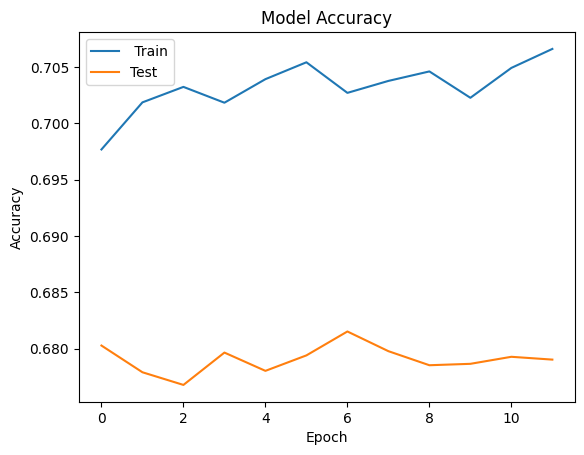

Epoch 1/100
63/63 [==============================] - 11s 68ms/step - loss: 0.5698 - accuracy: 0.7017 - precision_3: 0.7020 - recall_3: 0.6477 - val_loss: 0.5950 - val_accuracy: 0.6776 - val_precision_3: 0.6584 - val_recall_3: 0.6537
Epoch 2/100
63/63 [==============================] - 1s 23ms/step - loss: 0.5679 - accuracy: 0.7045 - precision_3: 0.7059 - recall_3: 0.6491 - val_loss: 0.5939 - val_accuracy: 0.6813 - val_precision_3: 0.6702 - val_recall_3: 0.6343
Epoch 3/100
63/63 [==============================] - 1s 23ms/step - loss: 0.5684 - accuracy: 0.7041 - precision_3: 0.7023 - recall_3: 0.6560 - val_loss: 0.5970 - val_accuracy: 0.6825 - val_precision_3: 0.6712 - val_recall_3: 0.6367
Epoch 4/100
63/63 [==============================] - 1s 23ms/step - loss: 0.5646 - accuracy: 0.7051 - precision_3: 0.7081 - recall_3: 0.6463 - val_loss: 0.5940 - val_accuracy: 0.6810 - val_precision_3: 0.6721 - val_recall_3: 0.6282
Epoch 5/100
63/63 [==============================] - 1s 22ms/step - los

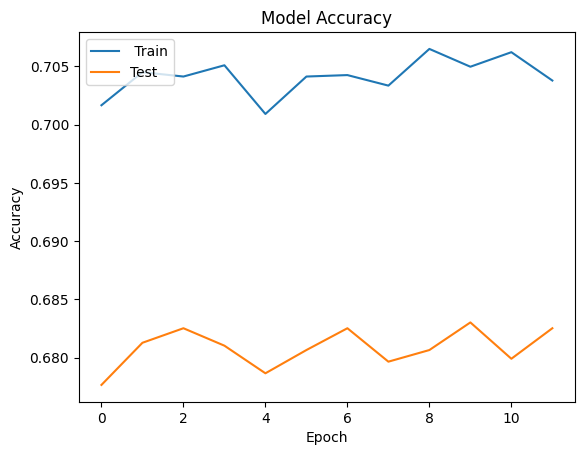

In [ ]:
batch = [64, 128, 256, 512]
for batch_size in batch:
  hist = train(model, "adam", 100, batch_size, x_train, y_train, x_val, y_val)
  evaluate_score(model, x_test, y_test)
  plot(hist)

In [ ]:
# extracting features and target using protparam approach1
data, target  = extract_feature(df)
data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.06666667],
       [0.        , 0.        , 0.        , ..., 0.06666667, 0.        ,
        0.06666667],
       [0.        , 0.        , 0.        , ..., 0.2       , 0.        ,
        0.13333333],
       ...,
       [0.        , 0.        , 0.        , ..., 0.13333333, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.06666667,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# preprocessing the data and create model
x = data
sc = StandardScaler()
x = sc.fit_transform(x)
y = target
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y)
model = create_model(x_train)

In [ ]:
# training model and evaluating scores with different batch size and optimizers and iterations

Epoch 1/100
501/501 [==============================] - 19s 16ms/step - loss: 0.6567 - accuracy: 0.6272 - precision_5: 0.6392 - recall_5: 0.4963 - val_loss: 0.5902 - val_accuracy: 0.6924 - val_precision_5: 0.6538 - val_recall_5: 0.7351
Epoch 2/100
501/501 [==============================] - 7s 14ms/step - loss: 0.5555 - accuracy: 0.7389 - precision_5: 0.7221 - recall_5: 0.7331 - val_loss: 0.5633 - val_accuracy: 0.7142 - val_precision_5: 0.6895 - val_recall_5: 0.7136
Epoch 3/100
501/501 [==============================] - 6s 12ms/step - loss: 0.4659 - accuracy: 0.8006 - precision_5: 0.7965 - recall_5: 0.7800 - val_loss: 0.5641 - val_accuracy: 0.7213 - val_precision_5: 0.7149 - val_recall_5: 0.6775
Epoch 4/100
501/501 [==============================] - 6s 12ms/step - loss: 0.3794 - accuracy: 0.8503 - precision_5: 0.8524 - recall_5: 0.8288 - val_loss: 0.5822 - val_accuracy: 0.7334 - val_precision_5: 0.7099 - val_recall_5: 0.7325
Epoch 5/100
501/501 [==============================] - 8s 16ms/

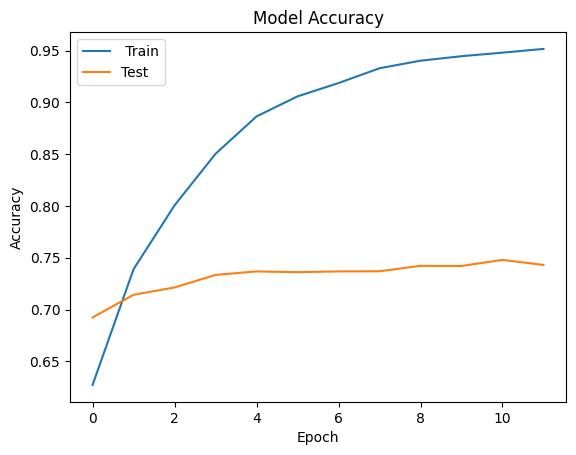

Epoch 1/100
251/251 [==============================] - 12s 21ms/step - loss: 0.4472 - accuracy: 0.8164 - precision_6: 0.8106 - recall_6: 0.8012 - val_loss: 0.5688 - val_accuracy: 0.7282 - val_precision_6: 0.7047 - val_recall_6: 0.7264
Epoch 2/100
251/251 [==============================] - 5s 20ms/step - loss: 0.3748 - accuracy: 0.8551 - precision_6: 0.8532 - recall_6: 0.8399 - val_loss: 0.5890 - val_accuracy: 0.7334 - val_precision_6: 0.7085 - val_recall_6: 0.7359
Epoch 3/100
251/251 [==============================] - 4s 16ms/step - loss: 0.3230 - accuracy: 0.8807 - precision_6: 0.8817 - recall_6: 0.8652 - val_loss: 0.6201 - val_accuracy: 0.7378 - val_precision_6: 0.7165 - val_recall_6: 0.7320
Epoch 4/100
251/251 [==============================] - 4s 14ms/step - loss: 0.2848 - accuracy: 0.8956 - precision_6: 0.8972 - recall_6: 0.8814 - val_loss: 0.6752 - val_accuracy: 0.7316 - val_precision_6: 0.7007 - val_recall_6: 0.7492
Epoch 5/100
251/251 [==============================] - 6s 22ms/

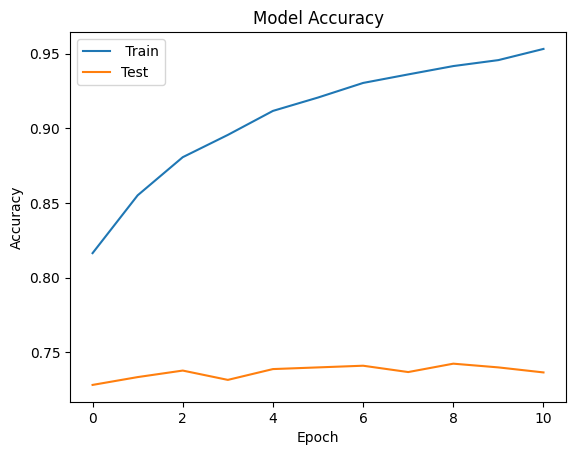

Epoch 1/100
126/126 [==============================] - 11s 31ms/step - loss: 0.3682 - accuracy: 0.8611 - precision_7: 0.8608 - recall_7: 0.8445 - val_loss: 0.5906 - val_accuracy: 0.7337 - val_precision_7: 0.7166 - val_recall_7: 0.7174
Epoch 2/100
126/126 [==============================] - 3s 24ms/step - loss: 0.3210 - accuracy: 0.8805 - precision_7: 0.8811 - recall_7: 0.8656 - val_loss: 0.6164 - val_accuracy: 0.7328 - val_precision_7: 0.7142 - val_recall_7: 0.7197
Epoch 3/100
126/126 [==============================] - 3s 27ms/step - loss: 0.2894 - accuracy: 0.8957 - precision_7: 0.8973 - recall_7: 0.8815 - val_loss: 0.6668 - val_accuracy: 0.7324 - val_precision_7: 0.7094 - val_recall_7: 0.7301
Epoch 4/100
126/126 [==============================] - 3s 20ms/step - loss: 0.2581 - accuracy: 0.9085 - precision_7: 0.9108 - recall_7: 0.8954 - val_loss: 0.6876 - val_accuracy: 0.7349 - val_precision_7: 0.7173 - val_recall_7: 0.7200
Epoch 5/100
126/126 [==============================] - 3s 20ms/

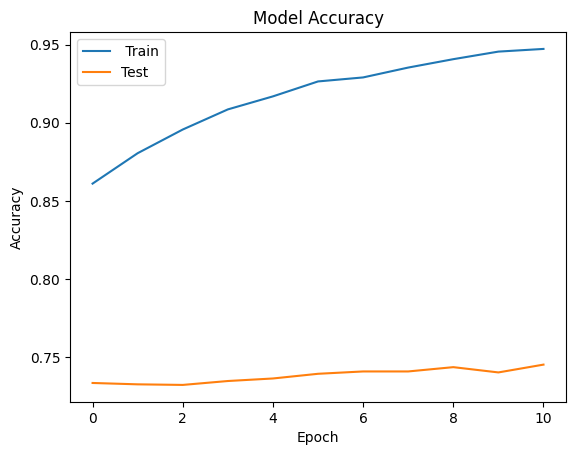

Epoch 1/100
63/63 [==============================] - 12s 53ms/step - loss: 0.3187 - accuracy: 0.8851 - precision_8: 0.8851 - recall_8: 0.8716 - val_loss: 0.6273 - val_accuracy: 0.7343 - val_precision_8: 0.7099 - val_recall_8: 0.7357
Epoch 2/100
63/63 [==============================] - 2s 30ms/step - loss: 0.2822 - accuracy: 0.9007 - precision_8: 0.9038 - recall_8: 0.8854 - val_loss: 0.6692 - val_accuracy: 0.7343 - val_precision_8: 0.7099 - val_recall_8: 0.7357
Epoch 3/100
63/63 [==============================] - 2s 30ms/step - loss: 0.2661 - accuracy: 0.9073 - precision_8: 0.9101 - recall_8: 0.8933 - val_loss: 0.6844 - val_accuracy: 0.7348 - val_precision_8: 0.7097 - val_recall_8: 0.7378
Epoch 4/100
63/63 [==============================] - 3s 41ms/step - loss: 0.2381 - accuracy: 0.9181 - precision_8: 0.9220 - recall_8: 0.9044 - val_loss: 0.7040 - val_accuracy: 0.7404 - val_precision_8: 0.7218 - val_recall_8: 0.7290
Epoch 5/100
63/63 [==============================] - 3s 42ms/step - los

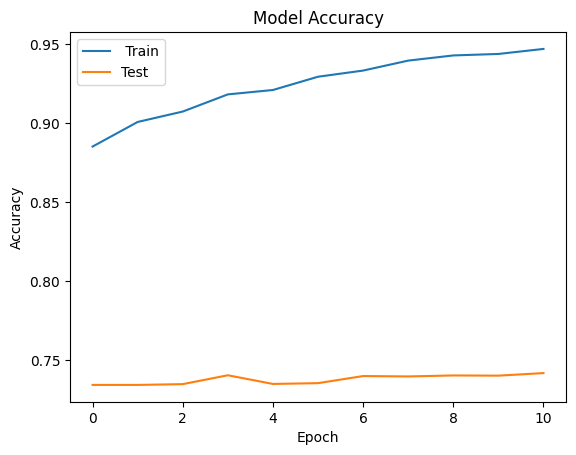

In [ ]:
batch = [64, 128, 256, 512]
for batch_size in batch:
  hist = train(model, "adam", 100, batch_size, x_train, y_train, x_val, y_val)
  evaluate_score(model, x_test, y_test)
  plot(hist)

Epoch 1/200
501/501 [==============================] - 15s 17ms/step - loss: 0.3262 - accuracy: 0.8764 - precision_9: 0.8768 - recall_9: 0.8611 - val_loss: 0.6127 - val_accuracy: 0.7311 - val_precision_9: 0.7025 - val_recall_9: 0.7426
Epoch 2/200
501/501 [==============================] - 6s 12ms/step - loss: 0.2902 - accuracy: 0.8949 - precision_9: 0.8952 - recall_9: 0.8823 - val_loss: 0.6602 - val_accuracy: 0.7313 - val_precision_9: 0.7023 - val_recall_9: 0.7439
Epoch 3/200
501/501 [==============================] - 7s 14ms/step - loss: 0.2601 - accuracy: 0.9075 - precision_9: 0.9121 - recall_9: 0.8914 - val_loss: 0.6836 - val_accuracy: 0.7382 - val_precision_9: 0.7117 - val_recall_9: 0.7450
Epoch 4/200
501/501 [==============================] - 6s 11ms/step - loss: 0.2314 - accuracy: 0.9173 - precision_9: 0.9228 - recall_9: 0.9015 - val_loss: 0.7137 - val_accuracy: 0.7437 - val_precision_9: 0.7219 - val_recall_9: 0.7399
Epoch 5/200
501/501 [==============================] - 7s 15ms/

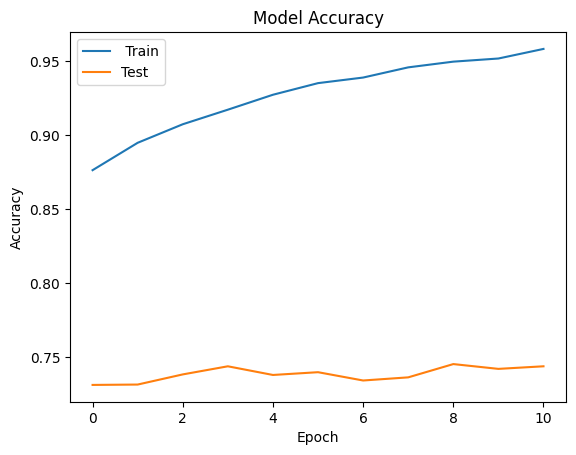

Epoch 1/200
251/251 [==============================] - 13s 21ms/step - loss: 0.2777 - accuracy: 0.8987 - precision_10: 0.8996 - recall_10: 0.8857 - val_loss: 0.6745 - val_accuracy: 0.7317 - val_precision_10: 0.7030 - val_recall_10: 0.7436
Epoch 2/200
251/251 [==============================] - 5s 20ms/step - loss: 0.2392 - accuracy: 0.9154 - precision_10: 0.9175 - recall_10: 0.9032 - val_loss: 0.7425 - val_accuracy: 0.7389 - val_precision_10: 0.7153 - val_recall_10: 0.7389
Epoch 3/200
251/251 [==============================] - 4s 15ms/step - loss: 0.2172 - accuracy: 0.9239 - precision_10: 0.9262 - recall_10: 0.9127 - val_loss: 0.7417 - val_accuracy: 0.7434 - val_precision_10: 0.7238 - val_recall_10: 0.7346
Epoch 4/200
251/251 [==============================] - 4s 16ms/step - loss: 0.1949 - accuracy: 0.9323 - precision_10: 0.9401 - recall_10: 0.9160 - val_loss: 0.8086 - val_accuracy: 0.7398 - val_precision_10: 0.7223 - val_recall_10: 0.7256
Epoch 5/200
251/251 [==========================

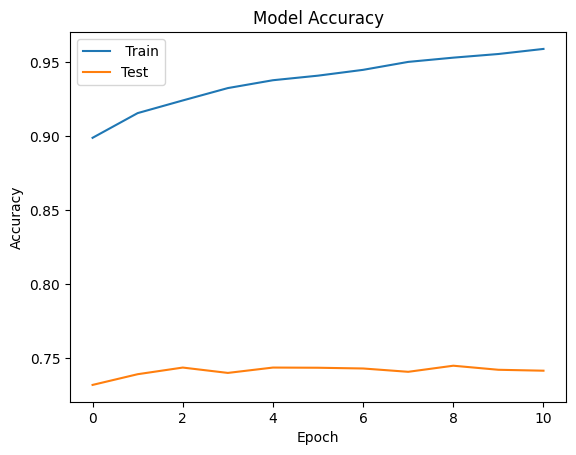

Epoch 1/200
126/126 [==============================] - 11s 32ms/step - loss: 0.2311 - accuracy: 0.9218 - precision_11: 0.9252 - recall_11: 0.9090 - val_loss: 0.7371 - val_accuracy: 0.7399 - val_precision_11: 0.7156 - val_recall_11: 0.7418
Epoch 2/200
126/126 [==============================] - 4s 33ms/step - loss: 0.2057 - accuracy: 0.9289 - precision_11: 0.9309 - recall_11: 0.9187 - val_loss: 0.7676 - val_accuracy: 0.7412 - val_precision_11: 0.7220 - val_recall_11: 0.7312
Epoch 3/200
126/126 [==============================] - 3s 23ms/step - loss: 0.1902 - accuracy: 0.9359 - precision_11: 0.9406 - recall_11: 0.9235 - val_loss: 0.7821 - val_accuracy: 0.7410 - val_precision_11: 0.7226 - val_recall_11: 0.7293
Epoch 4/200
126/126 [==============================] - 3s 20ms/step - loss: 0.1733 - accuracy: 0.9427 - precision_11: 0.9479 - recall_11: 0.9305 - val_loss: 0.8501 - val_accuracy: 0.7415 - val_precision_11: 0.7203 - val_recall_11: 0.7362
Epoch 5/200
126/126 [==========================

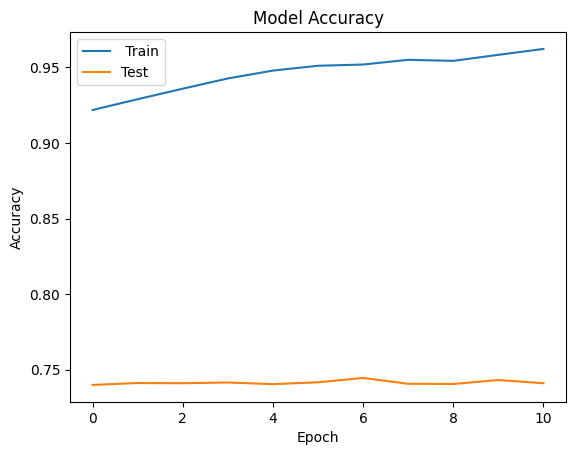

Epoch 1/200
63/63 [==============================] - 15s 56ms/step - loss: 0.1978 - accuracy: 0.9325 - precision_12: 0.9356 - recall_12: 0.9213 - val_loss: 0.7794 - val_accuracy: 0.7405 - val_precision_12: 0.7149 - val_recall_12: 0.7455
Epoch 2/200
63/63 [==============================] - 2s 27ms/step - loss: 0.1816 - accuracy: 0.9391 - precision_12: 0.9426 - recall_12: 0.9284 - val_loss: 0.8304 - val_accuracy: 0.7407 - val_precision_12: 0.7119 - val_recall_12: 0.7535
Epoch 3/200
63/63 [==============================] - 2s 35ms/step - loss: 0.1696 - accuracy: 0.9442 - precision_12: 0.9486 - recall_12: 0.9332 - val_loss: 0.8597 - val_accuracy: 0.7422 - val_precision_12: 0.7209 - val_recall_12: 0.7370
Epoch 4/200
63/63 [==============================] - 3s 44ms/step - loss: 0.1590 - accuracy: 0.9477 - precision_12: 0.9523 - recall_12: 0.9371 - val_loss: 0.8818 - val_accuracy: 0.7424 - val_precision_12: 0.7208 - val_recall_12: 0.7381
Epoch 5/200
63/63 [==============================] - 2s

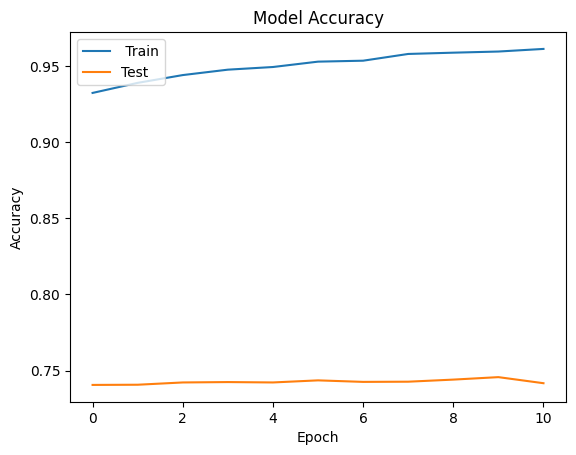

In [ ]:
batch = [64, 128, 256, 512]
for batch_size in batch:
  hist = train(model, "adam", 200, batch_size, x_train, y_train, x_val, y_val)
  evaluate_score(model, x_test, y_test)
  plot(hist)

# **pFeature dataset**

In [ ]:
# loading the pfeature datasets
aac = pd.read_csv("/content/drive/MyDrive/AAC_feature.csv")
dpc = pd.read_csv("/content/drive/MyDrive/DPC_feature.csv")
struct_pc = pd.read_csv("/content/drive/MyDrive/final_physico-chemical_result_structural.csv")
struct_pc = struct_pc.drop(['ID'],axis=1)
target = pd.read_csv("/content/drive/MyDrive/target.csv")

In [ ]:
# preprocessing the data and creating model with amino acid composition features
x = aac.values
sc = StandardScaler()
x = sc.fit_transform(x)
y = target.values
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y)
model = create_model(x_train)

Epoch 1/200
544/544 [==============================] - 14s 12ms/step - loss: 0.6581 - accuracy: 0.6379 - precision_13: 0.6332 - recall_13: 0.7070 - val_loss: 0.6215 - val_accuracy: 0.6648 - val_precision_13: 0.6679 - val_recall_13: 0.7065
Epoch 2/200
544/544 [==============================] - 6s 12ms/step - loss: 0.6286 - accuracy: 0.6612 - precision_13: 0.6601 - recall_13: 0.7065 - val_loss: 0.6092 - val_accuracy: 0.6760 - val_precision_13: 0.6678 - val_recall_13: 0.7496
Epoch 3/200
544/544 [==============================] - 5s 10ms/step - loss: 0.6215 - accuracy: 0.6687 - precision_13: 0.6644 - recall_13: 0.7220 - val_loss: 0.6046 - val_accuracy: 0.6761 - val_precision_13: 0.6586 - val_recall_13: 0.7828
Epoch 4/200
544/544 [==============================] - 6s 11ms/step - loss: 0.6166 - accuracy: 0.6721 - precision_13: 0.6661 - recall_13: 0.7293 - val_loss: 0.6034 - val_accuracy: 0.6777 - val_precision_13: 0.6789 - val_recall_13: 0.7213
Epoch 5/200
544/544 [==========================

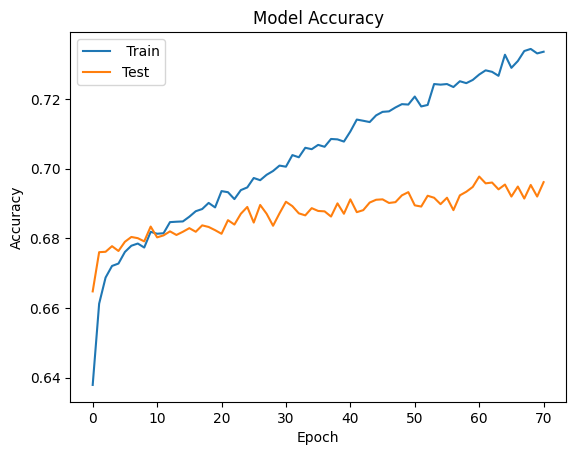

Epoch 1/200
272/272 [==============================] - 12s 18ms/step - loss: 0.5508 - accuracy: 0.7290 - precision_14: 0.7196 - recall_14: 0.7772 - val_loss: 0.5806 - val_accuracy: 0.6947 - val_precision_14: 0.6890 - val_recall_14: 0.7525
Epoch 2/200
272/272 [==============================] - 5s 18ms/step - loss: 0.5487 - accuracy: 0.7293 - precision_14: 0.7210 - recall_14: 0.7745 - val_loss: 0.5829 - val_accuracy: 0.6950 - val_precision_14: 0.6817 - val_recall_14: 0.7752
Epoch 3/200
272/272 [==============================] - 3s 12ms/step - loss: 0.5505 - accuracy: 0.7298 - precision_14: 0.7229 - recall_14: 0.7714 - val_loss: 0.5814 - val_accuracy: 0.6930 - val_precision_14: 0.6967 - val_recall_14: 0.7253
Epoch 4/200
272/272 [==============================] - 3s 12ms/step - loss: 0.5474 - accuracy: 0.7311 - precision_14: 0.7222 - recall_14: 0.7772 - val_loss: 0.5829 - val_accuracy: 0.6936 - val_precision_14: 0.6877 - val_recall_14: 0.7523
Epoch 5/200
272/272 [==========================

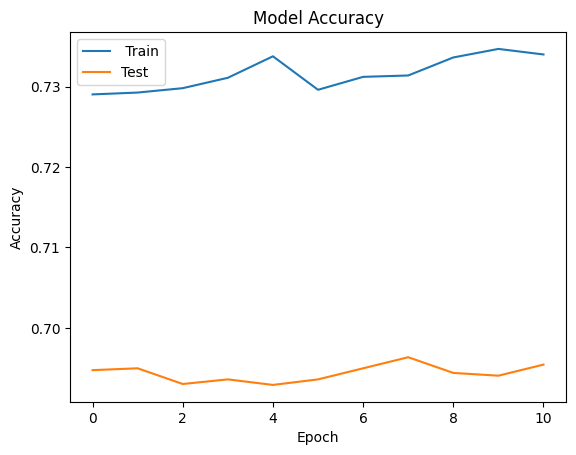

Epoch 1/200
136/136 [==============================] - 11s 27ms/step - loss: 0.5469 - accuracy: 0.7312 - precision_15: 0.7233 - recall_15: 0.7749 - val_loss: 0.5819 - val_accuracy: 0.6946 - val_precision_15: 0.6891 - val_recall_15: 0.7518
Epoch 2/200
136/136 [==============================] - 7s 53ms/step - loss: 0.5447 - accuracy: 0.7340 - precision_15: 0.7232 - recall_15: 0.7839 - val_loss: 0.5828 - val_accuracy: 0.6938 - val_precision_15: 0.6889 - val_recall_15: 0.7496
Epoch 3/200
136/136 [==============================] - 3s 20ms/step - loss: 0.5478 - accuracy: 0.7303 - precision_15: 0.7210 - recall_15: 0.7776 - val_loss: 0.5818 - val_accuracy: 0.6943 - val_precision_15: 0.6952 - val_recall_15: 0.7335
Epoch 4/200
136/136 [==============================] - 3s 19ms/step - loss: 0.5453 - accuracy: 0.7322 - precision_15: 0.7231 - recall_15: 0.7786 - val_loss: 0.5818 - val_accuracy: 0.6942 - val_precision_15: 0.6810 - val_recall_15: 0.7746
Epoch 5/200
136/136 [==========================

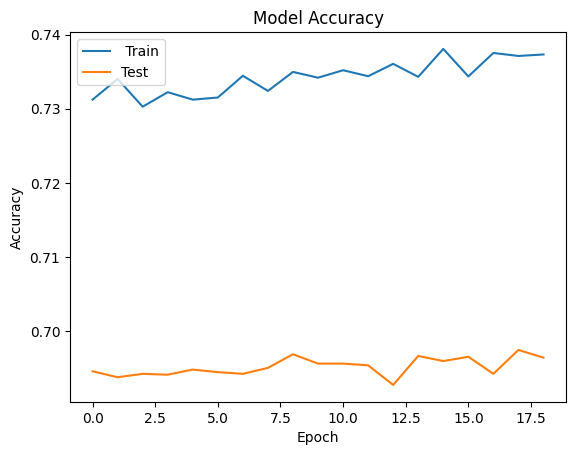

Epoch 1/200
68/68 [==============================] - 10s 52ms/step - loss: 0.5412 - accuracy: 0.7363 - precision_16: 0.7259 - recall_16: 0.7846 - val_loss: 0.5834 - val_accuracy: 0.6930 - val_precision_16: 0.6886 - val_recall_16: 0.7476
Epoch 2/200
68/68 [==============================] - 3s 44ms/step - loss: 0.5413 - accuracy: 0.7344 - precision_16: 0.7235 - recall_16: 0.7845 - val_loss: 0.5841 - val_accuracy: 0.6942 - val_precision_16: 0.6845 - val_recall_16: 0.7638
Epoch 3/200
68/68 [==============================] - 2s 32ms/step - loss: 0.5425 - accuracy: 0.7348 - precision_16: 0.7227 - recall_16: 0.7875 - val_loss: 0.5838 - val_accuracy: 0.6940 - val_precision_16: 0.6907 - val_recall_16: 0.7452
Epoch 4/200
68/68 [==============================] - 2s 31ms/step - loss: 0.5398 - accuracy: 0.7388 - precision_16: 0.7260 - recall_16: 0.7923 - val_loss: 0.5855 - val_accuracy: 0.6932 - val_precision_16: 0.6826 - val_recall_16: 0.7662
Epoch 5/200
68/68 [==============================] - 2s

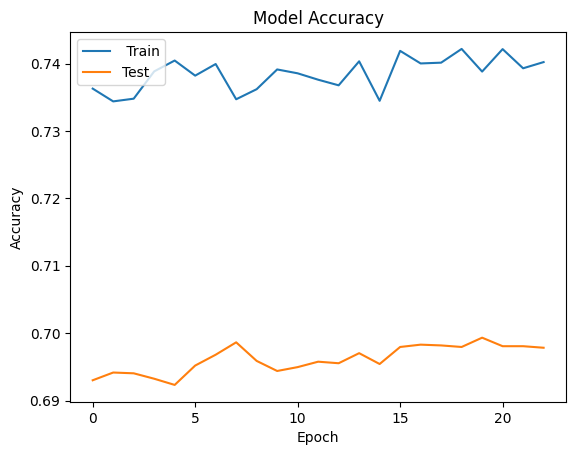

In [ ]:
# training model and evaluating scores with different batch size and optimizers and iterations
batch = [64, 128, 256, 512]
for batch_size in batch:
  hist = train(model, "adam", 200, batch_size, x_train, y_train, x_val, y_val)
  evaluate_score(model, x_test, y_test)
  plot(hist)

In [ ]:
# preprocessing the data and creating model with dipeptide composition features
x = dpc.values
sc = StandardScaler()
x = sc.fit_transform(x)
y = target.values
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y)
model = create_model(x_train)

Epoch 1/200
544/544 [==============================] - 15s 14ms/step - loss: 0.6424 - accuracy: 0.6459 - precision_17: 0.6299 - recall_17: 0.7591 - val_loss: 0.5885 - val_accuracy: 0.6978 - val_precision_17: 0.6933 - val_recall_17: 0.7509
Epoch 2/200
544/544 [==============================] - 8s 14ms/step - loss: 0.5406 - accuracy: 0.7535 - precision_17: 0.7460 - recall_17: 0.7911 - val_loss: 0.5562 - val_accuracy: 0.7252 - val_precision_17: 0.7255 - val_recall_17: 0.7582
Epoch 3/200
544/544 [==============================] - 7s 13ms/step - loss: 0.4490 - accuracy: 0.8124 - precision_17: 0.8117 - recall_17: 0.8282 - val_loss: 0.5522 - val_accuracy: 0.7377 - val_precision_17: 0.7269 - val_recall_17: 0.7936
Epoch 4/200
544/544 [==============================] - 7s 13ms/step - loss: 0.3682 - accuracy: 0.8558 - precision_17: 0.8579 - recall_17: 0.8632 - val_loss: 0.5625 - val_accuracy: 0.7489 - val_precision_17: 0.7441 - val_recall_17: 0.7878
Epoch 5/200
544/544 [==========================

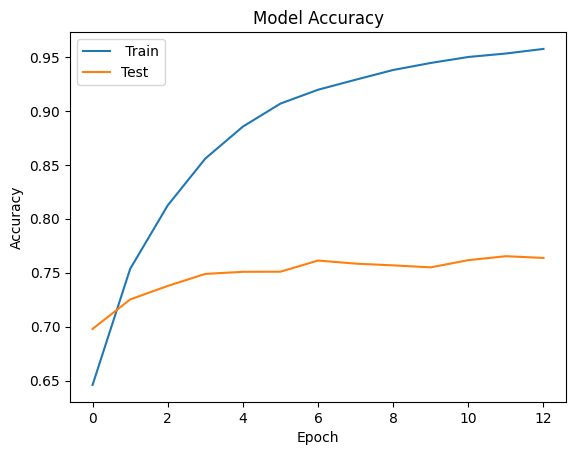

Epoch 1/200
272/272 [==============================] - 13s 21ms/step - loss: 0.3438 - accuracy: 0.8701 - precision_18: 0.8715 - recall_18: 0.8772 - val_loss: 0.5894 - val_accuracy: 0.7459 - val_precision_18: 0.7423 - val_recall_18: 0.7830
Epoch 2/200
272/272 [==============================] - 4s 16ms/step - loss: 0.2957 - accuracy: 0.8924 - precision_18: 0.8940 - recall_18: 0.8976 - val_loss: 0.6060 - val_accuracy: 0.7517 - val_precision_18: 0.7531 - val_recall_18: 0.7772
Epoch 3/200
272/272 [==============================] - 5s 20ms/step - loss: 0.2630 - accuracy: 0.9046 - precision_18: 0.9075 - recall_18: 0.9074 - val_loss: 0.6709 - val_accuracy: 0.7516 - val_precision_18: 0.7505 - val_recall_18: 0.7823
Epoch 4/200
272/272 [==============================] - 4s 16ms/step - loss: 0.2373 - accuracy: 0.9162 - precision_18: 0.9192 - recall_18: 0.9180 - val_loss: 0.6781 - val_accuracy: 0.7523 - val_precision_18: 0.7540 - val_recall_18: 0.7770
Epoch 5/200
272/272 [==========================

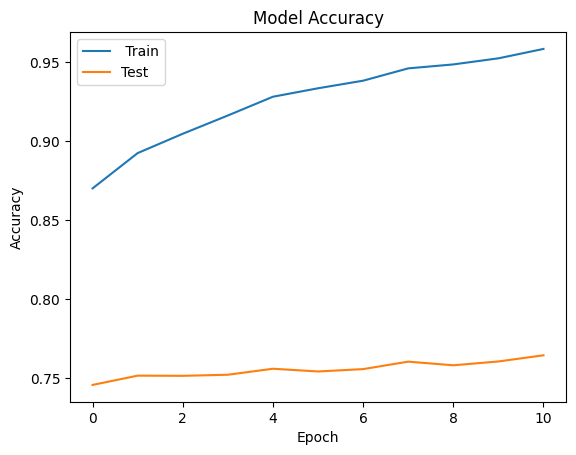

Epoch 1/200
136/136 [==============================] - 12s 30ms/step - loss: 0.2867 - accuracy: 0.8964 - precision_19: 0.9004 - recall_19: 0.8982 - val_loss: 0.6301 - val_accuracy: 0.7552 - val_precision_19: 0.7490 - val_recall_19: 0.7958
Epoch 2/200
136/136 [==============================] - 3s 20ms/step - loss: 0.2525 - accuracy: 0.9104 - precision_19: 0.9126 - recall_19: 0.9137 - val_loss: 0.6595 - val_accuracy: 0.7520 - val_precision_19: 0.7479 - val_recall_19: 0.7887
Epoch 3/200
136/136 [==============================] - 4s 27ms/step - loss: 0.2294 - accuracy: 0.9202 - precision_19: 0.9228 - recall_19: 0.9223 - val_loss: 0.7016 - val_accuracy: 0.7555 - val_precision_19: 0.7506 - val_recall_19: 0.7934
Epoch 4/200
136/136 [==============================] - 3s 24ms/step - loss: 0.2092 - accuracy: 0.9283 - precision_19: 0.9313 - recall_19: 0.9294 - val_loss: 0.7209 - val_accuracy: 0.7567 - val_precision_19: 0.7563 - val_recall_19: 0.7848
Epoch 5/200
136/136 [==========================

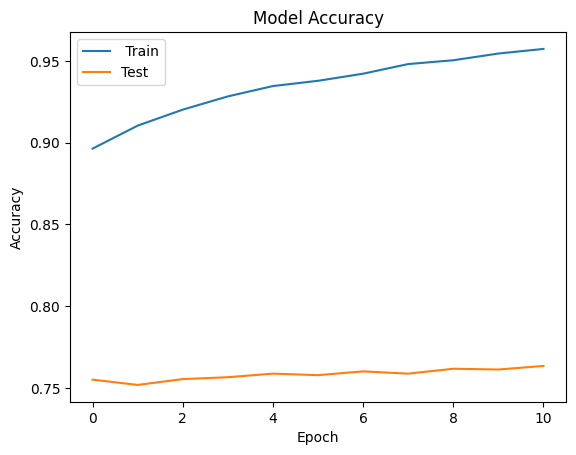

Epoch 1/200
68/68 [==============================] - 12s 75ms/step - loss: 0.2501 - accuracy: 0.9119 - precision_20: 0.9160 - recall_20: 0.9128 - val_loss: 0.6633 - val_accuracy: 0.7531 - val_precision_20: 0.7616 - val_recall_20: 0.7644
Epoch 2/200
68/68 [==============================] - 2s 33ms/step - loss: 0.2236 - accuracy: 0.9243 - precision_20: 0.9270 - recall_20: 0.9260 - val_loss: 0.6982 - val_accuracy: 0.7531 - val_precision_20: 0.7514 - val_recall_20: 0.7848
Epoch 3/200
68/68 [==============================] - 2s 32ms/step - loss: 0.2094 - accuracy: 0.9281 - precision_20: 0.9306 - recall_20: 0.9298 - val_loss: 0.7213 - val_accuracy: 0.7554 - val_precision_20: 0.7532 - val_recall_20: 0.7876
Epoch 4/200
68/68 [==============================] - 2s 32ms/step - loss: 0.1919 - accuracy: 0.9344 - precision_20: 0.9387 - recall_20: 0.9338 - val_loss: 0.7591 - val_accuracy: 0.7577 - val_precision_20: 0.7541 - val_recall_20: 0.7923
Epoch 5/200
68/68 [==============================] - 2s

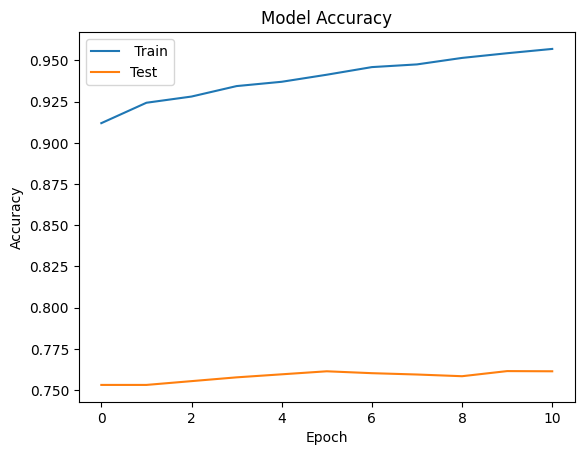

In [ ]:
# training model and evaluating scores with different batch size and optimizers and iterations
batch = [64, 128, 256, 512]
for batch_size in batch:
  hist = train(model, "adam", 200, batch_size, x_train, y_train, x_val, y_val)
  evaluate_score(model, x_test, y_test)
  plot(hist)

In [ ]:
# preprocessing the data and creating model with physio-chemical properties features
x = struct_pc.values
sc = StandardScaler()
x = sc.fit_transform(x)
y = target.values
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y)
model = create_model(x_train)

Epoch 1/200
544/544 [==============================] - 14s 14ms/step - loss: 0.6758 - accuracy: 0.6076 - precision_21: 0.5998 - recall_21: 0.7172 - val_loss: 0.6478 - val_accuracy: 0.6387 - val_precision_21: 0.6565 - val_recall_21: 0.6398
Epoch 2/200
544/544 [==============================] - 5s 9ms/step - loss: 0.6508 - accuracy: 0.6373 - precision_21: 0.6443 - recall_21: 0.6615 - val_loss: 0.6408 - val_accuracy: 0.6484 - val_precision_21: 0.6556 - val_recall_21: 0.6822
Epoch 3/200
544/544 [==============================] - 6s 12ms/step - loss: 0.6489 - accuracy: 0.6384 - precision_21: 0.6419 - recall_21: 0.6747 - val_loss: 0.6376 - val_accuracy: 0.6463 - val_precision_21: 0.6462 - val_recall_21: 0.7061
Epoch 4/200
544/544 [==============================] - 5s 9ms/step - loss: 0.6457 - accuracy: 0.6407 - precision_21: 0.6436 - recall_21: 0.6787 - val_loss: 0.6366 - val_accuracy: 0.6444 - val_precision_21: 0.6400 - val_recall_21: 0.7222
Epoch 5/200
544/544 [============================

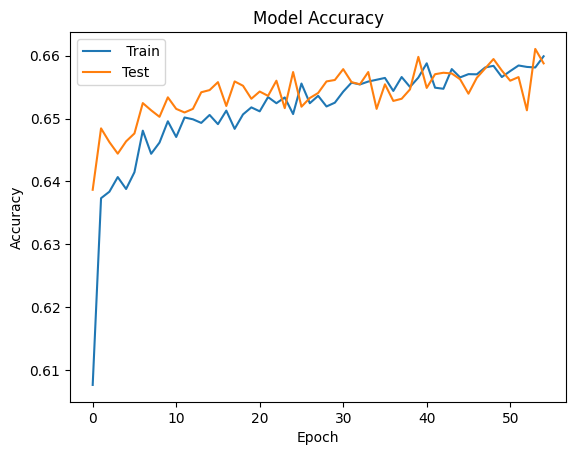

Epoch 1/200
272/272 [==============================] - 12s 17ms/step - loss: 0.6253 - accuracy: 0.6571 - precision_22: 0.6506 - recall_22: 0.7227 - val_loss: 0.6214 - val_accuracy: 0.6549 - val_precision_22: 0.6352 - val_recall_22: 0.7894
Epoch 2/200
272/272 [==============================] - 4s 13ms/step - loss: 0.6249 - accuracy: 0.6573 - precision_22: 0.6484 - recall_22: 0.7319 - val_loss: 0.6209 - val_accuracy: 0.6566 - val_precision_22: 0.6388 - val_recall_22: 0.7812
Epoch 3/200
272/272 [==============================] - 4s 15ms/step - loss: 0.6256 - accuracy: 0.6585 - precision_22: 0.6485 - recall_22: 0.7367 - val_loss: 0.6212 - val_accuracy: 0.6573 - val_precision_22: 0.6425 - val_recall_22: 0.7682
Epoch 4/200
272/272 [==============================] - 3s 12ms/step - loss: 0.6254 - accuracy: 0.6569 - precision_22: 0.6492 - recall_22: 0.7275 - val_loss: 0.6208 - val_accuracy: 0.6604 - val_precision_22: 0.6549 - val_recall_22: 0.7328
Epoch 5/200
272/272 [==========================

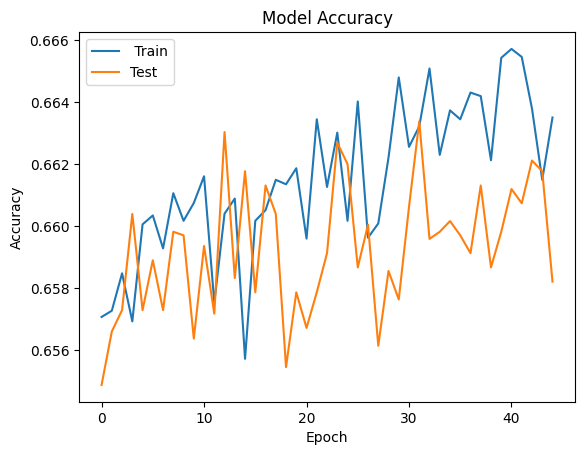

Epoch 1/200
136/136 [==============================] - 11s 26ms/step - loss: 0.6170 - accuracy: 0.6653 - precision_23: 0.6558 - recall_23: 0.7381 - val_loss: 0.6177 - val_accuracy: 0.6613 - val_precision_23: 0.6509 - val_recall_23: 0.7518
Epoch 2/200
136/136 [==============================] - 2s 16ms/step - loss: 0.6184 - accuracy: 0.6652 - precision_23: 0.6579 - recall_23: 0.7299 - val_loss: 0.6182 - val_accuracy: 0.6620 - val_precision_23: 0.6541 - val_recall_23: 0.7425
Epoch 3/200
136/136 [==============================] - 2s 17ms/step - loss: 0.6157 - accuracy: 0.6687 - precision_23: 0.6587 - recall_23: 0.7410 - val_loss: 0.6175 - val_accuracy: 0.6596 - val_precision_23: 0.6427 - val_recall_23: 0.7775
Epoch 4/200
136/136 [==============================] - 3s 22ms/step - loss: 0.6170 - accuracy: 0.6618 - precision_23: 0.6531 - recall_23: 0.7333 - val_loss: 0.6183 - val_accuracy: 0.6606 - val_precision_23: 0.6582 - val_recall_23: 0.7222
Epoch 5/200
136/136 [==========================

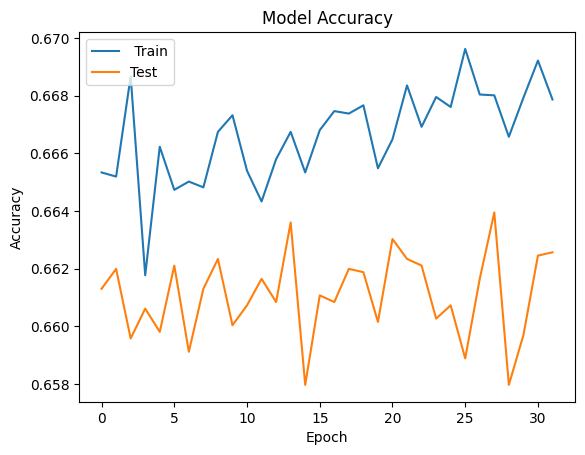

Epoch 1/200
68/68 [==============================] - 13s 86ms/step - loss: 0.6147 - accuracy: 0.6672 - precision_24: 0.6597 - recall_24: 0.7317 - val_loss: 0.6175 - val_accuracy: 0.6583 - val_precision_24: 0.6471 - val_recall_24: 0.7540
Epoch 2/200
68/68 [==============================] - 2s 35ms/step - loss: 0.6145 - accuracy: 0.6689 - precision_24: 0.6589 - recall_24: 0.7415 - val_loss: 0.6175 - val_accuracy: 0.6622 - val_precision_24: 0.6516 - val_recall_24: 0.7527
Epoch 3/200
68/68 [==============================] - 4s 57ms/step - loss: 0.6125 - accuracy: 0.6692 - precision_24: 0.6604 - recall_24: 0.7371 - val_loss: 0.6179 - val_accuracy: 0.6610 - val_precision_24: 0.6491 - val_recall_24: 0.7571
Epoch 4/200
68/68 [==============================] - 3s 45ms/step - loss: 0.6127 - accuracy: 0.6676 - precision_24: 0.6596 - recall_24: 0.7339 - val_loss: 0.6171 - val_accuracy: 0.6622 - val_precision_24: 0.6522 - val_recall_24: 0.7505
Epoch 5/200
68/68 [==============================] - 2s

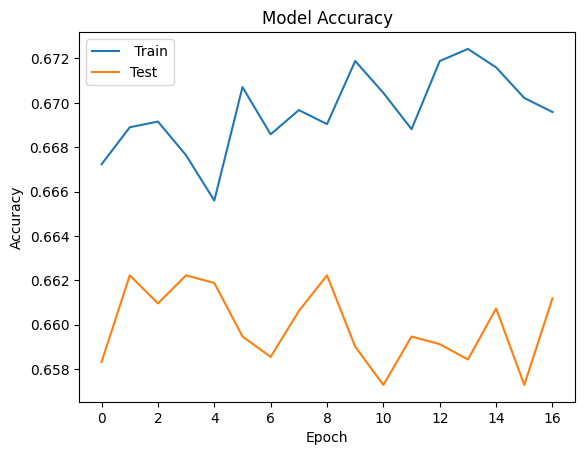

In [ ]:
# training model and evaluating scores with different batch size and optimizers and iterations
batch = [64, 128, 256, 512]
for batch_size in batch:
  hist = train(model, "adam", 200, batch_size, x_train, y_train, x_val, y_val)
  evaluate_score(model, x_test, y_test)
  plot(hist)